In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('//content/gdrive/My Drive/Colab Notebooks/')

In [0]:
#export
from exp.nb_08 import *

##Optimizer tweaks

###imagenette data

In [0]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [0]:
nfs = [32,64,128,256]

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy),CudaCallback,partial(BatchTransformXCallback,norm_imagenette)]

In [0]:
learn,run = get_learn_run(nfs,data,0.4,conv_layer,cbs=cbfs)

In [7]:
run.fit(1,learn)

train: [1.7872202550604932, tensor(0.3758, device='cuda:0')]
valid: [1.734029052734375, tensor(0.3940, device='cuda:0')]


In [0]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]
        self.steppers = listify(steppers)

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [0]:
#export
def sgd_step(p,lr,**kwargs):
  p.data.add_(-lr,p.grad.data)
  return p

In [0]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [0]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self): 
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): h[self.pname] = f(pos)
            
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [0]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, Recorder,
        partial(ParamScheduler, 'lr', sched)]

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=opt_func)

In [15]:
%time run.fit(1, learn)


train: [1.7422923210407941, tensor(0.3931, device='cuda:0')]
valid: [1.388708984375, tensor(0.5400, device='cuda:0')]
CPU times: user 3.72 s, sys: 2.36 s, total: 6.08 s
Wall time: 21.9 s


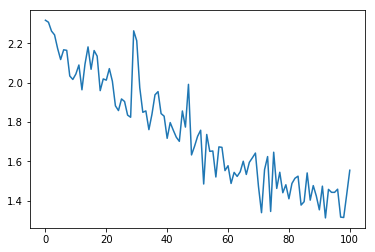

In [16]:
run.recorder.plot_loss()

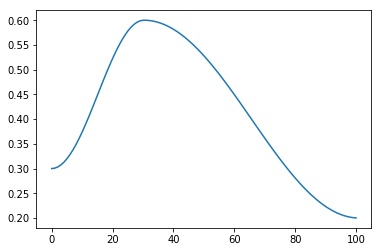

In [17]:
run.recorder.plot_lr()

###weight decay

In [0]:
#export
def weight_decay(p, lr, wd, **kwargs):
  p.data.mul_(1-lr*wd)
  return p
weight_decay._defaults=dict(wd=0.)

In [0]:
#export
def l2_reg(p,lr,wd,**kwargs):
  p.grad.data.add_(wd,p.data)
  return p
l2_reg.defaults = dict(wd=0.)

In [0]:
#export
def maybe_update(os, dest, f):
    for o in os:
        for k,v in f(o).items():
            if k not in dest: dest[k] = v

def get_defaults(d): return getattr(d,'_defaults',{})

In [0]:
#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [0]:
#export
sgd_opt = partial(Optimizer, steppers=[weight_decay,sgd_step])

In [0]:
learn,run = get_learn_run(nfs,data,0.4,conv_layer,cbs=cbfs,opt_func=sgd_opt)

In [0]:
model = learn.model

In [0]:
opt = sgd_opt(model.parameters(),lr=0.1)
test_eq(opt.hypers[0]['wd'],0)
test_eq(opt.hypers[0]['lr'],0.1)

In [0]:
opt = sgd_opt(model.parameters(),lr=0.1,wd=1e-4)
test_eq(opt.hypers[0]['wd'],1e-4)
test_eq(opt.hypers[0]['lr'],0.1)

In [0]:
cbfs=[partial(AvgStatsCallback,accuracy),CudaCallback]

In [0]:
learn,run = get_learn_run(nfs,data,0.3,conv_layer,cbs=cbfs,opt_func=partial(sgd_opt,wd=0.01))

In [29]:
run.fit(1,learn)

train: [1.8083435124864278, tensor(0.3726, device='cuda:0')]
valid: [1.904537109375, tensor(0.3360, device='cuda:0')]


### Momentum

In [0]:
#export
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults): 
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for p,hyper in self.grad_params():
            if p not in self.state:
                #Create a state for p and call all the statistics to initialize it.
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats: state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

In [0]:
#export
class Stat():
    _defaults = {}
    def init_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError

In [0]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)
        return state

In [0]:
#export
def momentum_step(p,lr,grad_avg,**kwargs):
  p.data.add_(-lr,grad_avg)
  return p

In [0]:
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step,weight_decay],
                     stats=AverageGrad(), wd=0.01)

In [0]:
learn,run = get_learn_run(nfs,data,0.3,conv_layer,cbs=cbfs,opt_func=sgd_mom_opt)

In [36]:
run.fit(1,learn)

train: [1.743716796572049, tensor(0.3994, device='cuda:0')]
valid: [1.93164990234375, tensor(0.2880, device='cuda:0')]


###momentum

In [0]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
betas = [0.5, 0.7, 0.9, 0.99]

In [0]:
def plot_mom(f):
  _,axs = plt.subplots(2,2,figsize=(12,8))
  for beta,ax in zip(betas,axs.flatten()):
    ax.plot(y,linestyle='None',marker='.')
    avg,res = None,[]
    for i,yi in enumerate(y):
      avg,p = f(avg,beta,yi,i)
      res.append(p)
    ax.plot(res,color='red')
    ax.set_title(f'beta={beta}')

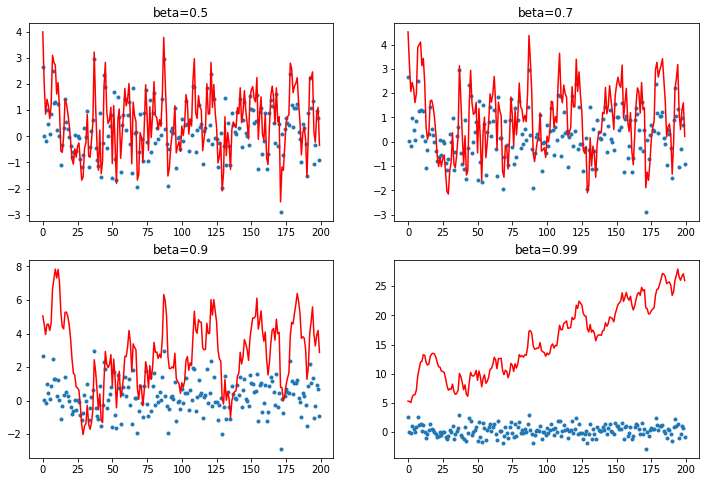

In [39]:
def mom1(avg,beta,yi,i):
  if avg is None: avg=yi
  res = beta*avg + yi
  return res,res
plot_mom(mom1)

In [0]:
#export
def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2

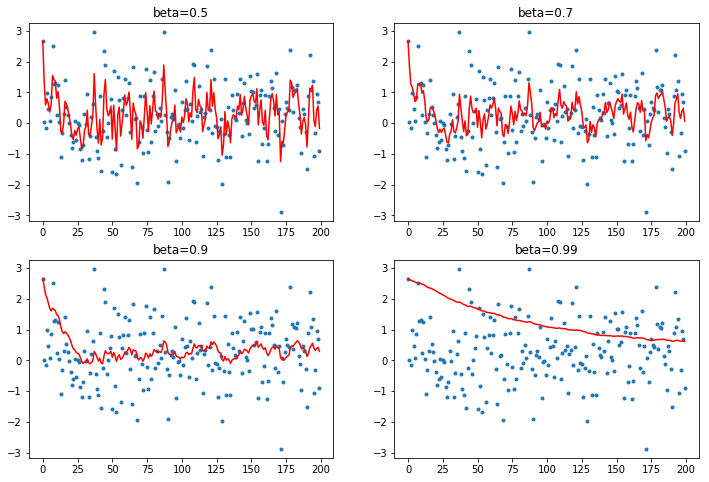

In [41]:
def mom2(avg, beta, yi, i):
    if avg is None: avg=yi
    avg = lin_comb(avg, yi, beta)
    return avg, avg
plot_mom(mom2)

In [0]:
y=1-(x/3)**2 + torch.randn(200)*0.1

In [0]:
y[0]=0.5

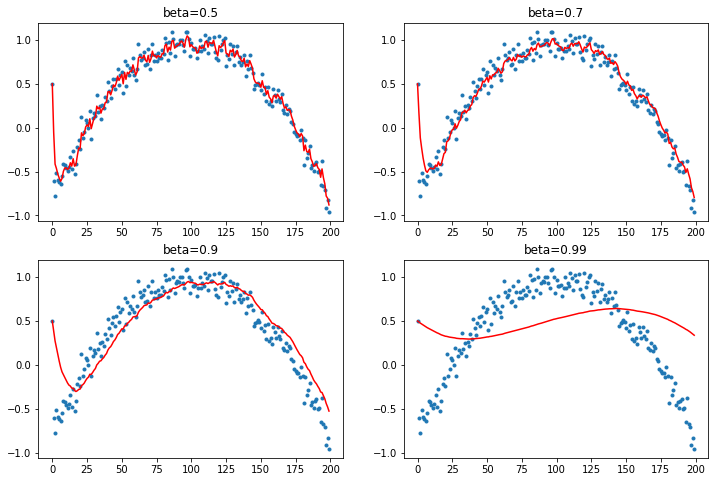

In [44]:
plot_mom(mom2)

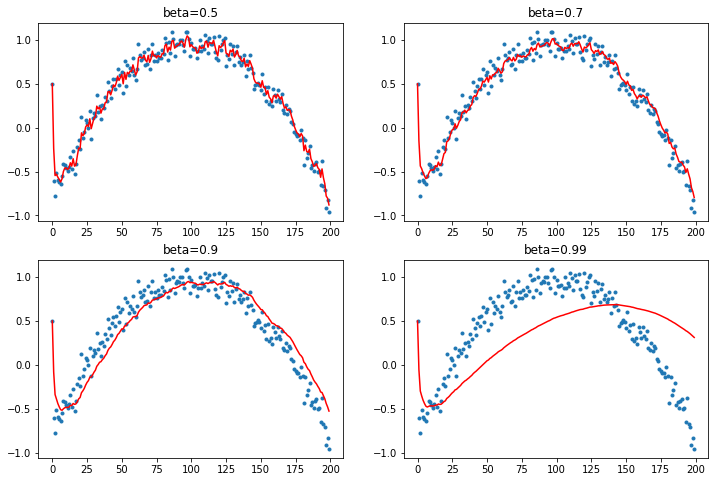

In [45]:
def mom3(avg, beta, yi, i):
    if avg is None: avg=0
    avg = lin_comb(avg, yi, beta)
    return avg, avg/(1-beta**(i+1))
plot_mom(mom3)

###Adam

In [0]:
#export
class AverageGrad(Stat):
  _defaults=dict(mom=0.9)
  def __init__(self,dampening:bool=False): self.dampening=dampening
  def init_state(self,p): return {'grad_avg': torch.zeros_like(p.grad.data)}
  def update(self,p,state,mom,**kwargs):
    state['mom_damp']=1-mom if self.dampening else 1.
    state['grad_avg'].mul_(mom).add_(state['mom_damp'],p.grad.data)
    return state

In [0]:
#export
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True): self.dampening=dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

In [0]:
#export
class StepCount(Stat):
  def init_state(self,p): return {'step':0}
  def update(self,p,state,**kwargs):
    state['step']+=1
    return state

In [0]:
#export
def debias(mom,damp,step): return damp*(1-mom**step)/(1-mom)

In [0]:
#export
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p
adam_step._defaults = dict(eps=1e-5)

In [0]:
#export
def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[adam_step,weight_decay]+listify(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **kwargs)

In [0]:
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, cbs=cbfs, opt_func=adam_opt())

In [62]:
run.fit(3, learn)


train: [1.7328394929327595, tensor(0.4013, device='cuda:0')]
valid: [1.3900458984375, tensor(0.5080, device='cuda:0')]
train: [1.25828427042132, tensor(0.5925, device='cuda:0')]
valid: [1.18015087890625, tensor(0.6020, device='cuda:0')]
train: [0.997609413777726, tensor(0.6758, device='cuda:0')]
valid: [1.082289794921875, tensor(0.6200, device='cuda:0')]


###LAMB

In [0]:

def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps) + wd*p.data
    r2 = step.pow(2).mean().sqrt()
    p.data.add_(-lr * min(r1/r2,10), step)
    return p
lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [0]:
lamb = partial(StatefulOptimizer, steppers=lamb_step, stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [0]:
learn,run = get_learn_run(nfs, data, 0.003, conv_layer, cbs=cbfs, opt_func=lamb)

In [67]:
run.fit(3, learn)

train: [1.8824377496316116, tensor(0.3475, device='cuda:0')]
valid: [1.5322657470703125, tensor(0.4680, device='cuda:0')]
train: [1.395285295001551, tensor(0.5390, device='cuda:0')]
valid: [1.3686295166015625, tensor(0.5280, device='cuda:0')]
train: [1.1327577416094696, tensor(0.6308, device='cuda:0')]
valid: [1.1207957763671874, tensor(0.6320, device='cuda:0')]


###export

In [0]:
!python notebook2script.py 09_optimizers.ipynb